# XBRAIN Demo Notebook

Last Update: 10/12/2017

In [1]:
# Imports 
import numpy as np
from PIL import Image
import xbrain
import intern
from intern.remote.dvid import DVIDRemote
import time
import os

In [2]:
#This is the only function in ndparse we use throughout the code, so I have decided to include the raw function's code here instead. 

def ndplot(im1, im2=None, cmap1='gray', cmap2='jet', slice=0,
         alpha=1, show_plot=True, save_plot=False):
    """
    Convenience function to handle plotting of neurodata arrays.
    Mostly tested with 8-bit image and 32-bit annos, but lots of
    things should work.  Mimics (and uses) matplotlib, but transparently
    deals with RAMON objects, transposes, and overlays.  Slices 3D arrays
    and allows for different blending when using overlays.  We require
    (but verify) that dimensions are the same when overlaying.
    Arguments:
        im1 (array): RAMONObject or numpy array
        im2 (array) [None]:  RAMONObject or numpy array
        cmap1 (string ['gray']): Colormap for base image
        cmap2 (string ['jet']): Colormap for overlay image
        slice (int) [0]: Used to choose slice from 3D array
        alpha (float) [1]: Used to set blending option between 0-1
    Returns:
        None.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # get im1_proc as 2D array
    fig = plt.figure()
    # fig.set_size_inches(2, 2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    base_image = False
    im1_proc = None

    if hasattr(im1, 'cutout') and im1.cutout is not None:
        im1_proc = im1.cutout
    elif im1 is not None:
        im1_proc = im1

    if im1_proc is not None and len(np.shape(im1_proc)) == 3:
        im1_proc = im1_proc[:, :, slice]

    if im1_proc is not None:
        base_image = True

    # get im2_proc as 2D array if exists
    overlay_image = False
    im2_proc = None

    if im2 is not None:

        if hasattr(im2, 'cutout') and im2.cutout is not None:
            im2_proc = im2.cutout
        elif im2 is not None:
            im2_proc = im2

        if im2_proc is not None and len(np.shape(im2_proc)) == 3:
            im2_proc = im2_proc[:, :, slice]

    if im2_proc is not None and np.shape(im1_proc) == np.shape(im2_proc):
        overlay_image = True

    if base_image:

        plt.imshow(im1_proc.T, cmap=cmap1, interpolation='bilinear')

    if base_image and overlay_image and alpha == 1:
        # This option is often recommended but seems less good in general.
        # Produces nice solid overlays for things like ground truth
        im2_proc = np.ma.masked_where(im2_proc == 0, im2_proc)
        plt.imshow(im2_proc.T, cmap=cmap2, interpolation='nearest')

    elif base_image and overlay_image and alpha < 1:

        plt.hold(True)
        im2_proc = np.asarray(im2_proc, dtype='float')  # TODO better way
        im2_proc[im2_proc == 0] = np.nan  # zero out bg
        plt.imshow(im2_proc.T, cmap=cmap2,
                   alpha=alpha, interpolation='nearest')

    if save_plot is not False:
        # TODO: White-space
        plt.savefig(save_plot, dpi=300, pad_inches=0)

    if show_plot is True:
        plt.show()

    pass

## Initialize
- Path of files
- Parameters for ilastik
- Parameters for cell detection
- Parameters for blood vessel segmentation

In [15]:
# Set folder where data is stored
current_dir = os.path.abspath(os.getcwd())

# THIS IS NOT WORKING
#folder = next(os.walk('.'))[1][0]
###############

print(os.path.exists(folder)) # testing

# ilastik parameters
classifier_file = current_dir + '/xbrain_vessel_seg_v7.ilp'
print(classifier_file)                 # testing
print(os.path.exists(classifier_file)) # testing

# testing ground truth
image_file = current_dir + '/V3_imgdata_gt.npy'
print(image_file)                 # testing
print(os.path.exists(image_file)) # testing


# Dictate the processing power
ram_size = 4000 # 4000 MB                                                                            
no_of_threads = 8 # 8 threads

# Cell detection parameters                                                                         
cell_probability_threshold  = 0.2
stopping_criterion = 0.47
initial_template_size = 18
dilation_size = 8
max_no_cells = 500

# Vessel segmentation parameters                                                                    
vessel_probability_threshold = .68
dilation_size = 3
minimum_size = 4000

True
/home/jovyan/work/Demo/xbrain_vessel_seg_v7.ilp
True
/home/jovyan/work/Demo/V3_imgdata_gt.npy
True


## Load in the data

Grabbing your cutout...
(200, 200, 200)


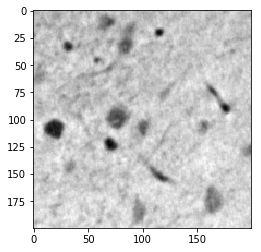

In [36]:
#DVID Data fetch:
dvid = DVIDRemote({
    "protocol": "http",
    "host": "143.215.230.214:8000",
    })

# remember to update your UUID
chan = "565d6229328e45ccb6f479403593c6ff/MaskedImg1"

input_data = dvid.get_cutout(
    dvid.get_channel(chan),0,
    [1400,1600],[1800,2000],[390,590]
    )

# get the shape of the data
print(input_data.shape) # (200, 200, 200)

imgplot = plt.imshow(input_data[0,:,:], cmap = "gray")
plt.show()


## Ingest data and classifer into ilastik

In [35]:
# Compute time required for processing
start = time.time()

# Process the data to probability maps
probability_maps = xbrain.classify_pixel(input_data, classifier_file, threads=no_of_threads, ram=ram_size)

end = time.time()
print("\nElapsed time: %f minutes" % ((end - start)/60))

ImportError: /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `CXXABI_1.3.9' not found (required by /opt/conda/lib/python3.6/site-packages/scipy/sparse/_sparsetools.cpython-36m-x86_64-linux-gnu.so)

## Display the results of ilastik

In [8]:
# pull down the coorisponding matricies
cell_prob_map = probability_maps[:, :, :, 2]
vessel_prob_map = probability_maps[:, :, :, 1]

print("cell_prob_map shape", cell_prob_map.shape)
ndplot(cell_prob_map, slice=50, cmap1='jet', alpha=0.5)


print("vessel_prob_map shape", vessel_prob_map.shape)
ndplot(vessel_prob_map, slice=50, cmap1='jet')


NameError: name 'probability_maps' is not defined

## Running different package for testing new algorithm

In [90]:
# reload packages for testing new algorithms
# import importlib
# importlib.reload(xbrain)

# Compute time required for processing
start = time.time()

# cell detection
centroids, cell_map = xbrain.detect_cells(cell_prob_map, cell_probability_threshold, stopping_criterion, initial_template_size, dilation_size, max_no_cells)
print(centroids)

end = time.time()
print("\nElapsed time: %f minutes" % ((end - start)/60))

WARNING _bootstrap.py(205): ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__


Iteration remaining =  499 Correlation =  [[ 0.95168388]]
Iteration remaining =  489 Correlation =  [[ 0.91369426]]
Iteration remaining =  479 Correlation =  [[ 0.88610667]]
Iteration remaining =  469 Correlation =  [[ 0.86151671]]
Iteration remaining =  459 Correlation =  [[ 0.85078424]]
Iteration remaining =  449 Correlation =  [[ 0.84014732]]
Iteration remaining =  439 Correlation =  [[ 0.82743627]]
Iteration remaining =  429 Correlation =  [[ 0.81597131]]
Iteration remaining =  419 Correlation =  [[ 0.80801356]]
Iteration remaining =  409 Correlation =  [[ 0.79984474]]
Iteration remaining =  399 Correlation =  [[ 0.78171575]]
Iteration remaining =  389 Correlation =  [[ 0.76294184]]
Iteration remaining =  379 Correlation =  [[ 0.74776268]]
Iteration remaining =  369 Correlation =  [[ 0.72482878]]
Iteration remaining =  359 Correlation =  [[ 0.70334792]]
Iteration remaining =  349 Correlation =  [[ 0.69173962]]
Iteration remaining =  339 Correlation =  [[ 0.67132163]]
Iteration rema

In [91]:
# find vessels

vessel_map = xbrain.segment_vessels(vessel_prob_map, vessel_probability_threshold, dilation_size, minimum_size)

## Display results of new algorithm

WARNING assess.py(299): MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
WARNING __init__.py(917): UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
WARNING rcsetup.py(152): UserWarning: axes.hold is deprecated, will be removed in 3.0


Vessel Segmentation


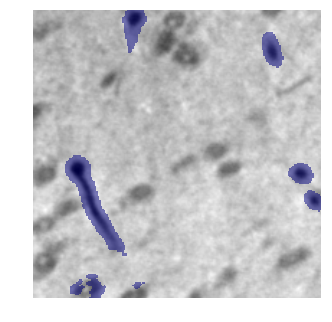

Cell Segmentation


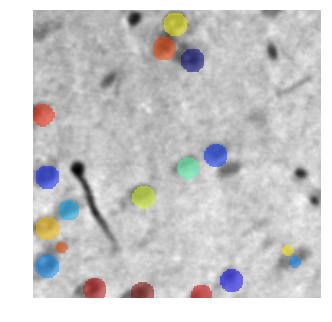

In [95]:
# show results

print("Vessel Segmentation")
ndplot(input_data, vessel_map, slice = 50, alpha = 0.5)

print("Cell Segmentation")
ndplot(input_data, cell_map, slice = 50, alpha = 0.5)


#### Thank you for going throught the XBRAIN tutorial!  For more information about the lab, please visit: [dyerlab.gatech.edu](http://dyerlab.gatech.edu)